In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import skimage
from tqdm import tqdm
import keras
from keras.datasets import mnist, cifar10, fashion_mnist

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [3]:
X_train.shape

(60000, 28, 28)

In [4]:
def cv2_rotate(image, degrees):
    if len(image.shape) == 3:
        rows, cols, _ = image.shape
    else:
        rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2), degrees, 1)
    return cv2.warpAffine(image, M, (cols,rows))

In [5]:
def pad(image, padding=2):
    
    h, w = image.shape
    image_padded = np.zeros((h + 2*padding, w + 2*padding))
    image_padded[padding:-padding, padding:-padding] = image
    return image_padded

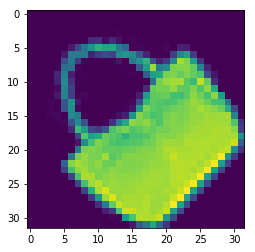

In [6]:
plt.imshow(cv2_rotate(pad(X_train[100]), 45))

In [7]:
augmented_rotations_per_sample = 3

In [8]:
def generate_random_rotations(X, Y, n_rotations_per_sample, rot_range=10):
    
    new_X = []
    new_Y = []
    rotations = []
    
    h, w = X.shape[1:]
    bigger = 2
    
    for image, label in tqdm(zip(X, Y), total=len(X)):
        
        image = pad(image)
        
        for _ in range(n_rotations_per_sample):
            
            rotation = np.random.randint(-rot_range, rot_range)
            rotated_image = cv2_rotate(image, rotation)
            new_X.append(rotated_image)
            new_Y.append(label)
            rotations.append(rotation)
    
    new_X = np.array(new_X)
    if len(new_X.shape) == 3:
        new_X = np.expand_dims(new_X, 3)
        
    return new_X, np.array(new_Y), np.array(rotations)

In [9]:
X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, augmented_rotations_per_sample)
X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, augmented_rotations_per_sample)

Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

100%|██████████| 10000/10000 [00:00<00:00, 16276.04it/s]


In [10]:
nb_classes = Y_train_onehot.shape[1]

In [11]:
R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

In [12]:
def create_rot_sin_cos(R_radians):
    rot_sin_cos = np.empty((len(R_radians), 2))
    rot_sin_cos[:, 0] = np.sin(R_radians)
    rot_sin_cos[:, 1] = np.cos(R_radians)
    return rot_sin_cos

In [13]:
R_train_sin_cos = create_rot_sin_cos(R_train_radians)
R_test_sin_cos = create_rot_sin_cos(R_test_radians)

In [14]:
from keras import layers
from keras import models
from keras import losses
import keras.backend as K

def cosine_proximity_unitary(y_true, y_pred):
    
    dot_product_loss = losses.cosine_proximity(y_true, y_pred)
    unit_circle_loss = K.square(1 - (K.square(y_pred[:, 0]) + K.square(y_pred[:, 1])))
    return dot_product_loss + 0.05 * unit_circle_loss


def build_model(use_labels=True, use_rotation=True):

    input_layer = layers.Input(X_train_rot.shape[1:], name='image_input')
    x = input_layer

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPool2D()(x)
    x = layers.Dropout(0.25)(x)
    flatten = layers.Flatten()(x)
    
    if use_labels:
        y = layers.Dense(128, activation='relu')(flatten)
        y = layers.Dropout(0.25)(y)
        y = layers.Dense(nb_classes, activation='softmax', name='y')(y)

    if use_rotation:
        r = layers.Dense(32, activation='relu')(flatten)
        r = layers.Dropout(0.5)(r)
        r = layers.Dense(2, name='r')(r)

    if use_labels and use_rotation:
        model = models.Model(input_layer, [y, r])        
        model.compile(optimizer='adam', loss=['categorical_crossentropy', 'cosine_proximity'], 
                      metrics=['accuracy'], loss_weights=[alpha, beta])
    elif use_labels:
        model = models.Model(input_layer, y)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    elif use_rotation:
        model = models.Model(input_layer, r)
        model.compile(optimizer='adam', loss='cosine_proximity', metrics=['accuracy'])
    else:
        raise ValueError('Specify at least 1 output for the network!')
        
    #model.summary()
    
    return model

In [15]:
from keras import callbacks

class LossWeightsCallback(callbacks.Callback):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 1:
            self.alpha = self.alpha - 0.4 # set to 0.5
            self.beta = self.beta + 0.4 # set to 0.5

In [16]:
def train_model(model, use_labels=True, use_rotation=True):
    
    if use_labels and use_rotation:
        y_train = [Y_train_onehot, R_train_sin_cos]
        y_test = [Y_test_onehot, R_test_sin_cos]
    elif use_labels:
        y_train = Y_train_onehot
        y_test = Y_test_onehot
    elif use_rotation:
        y_train = R_train_sin_cos
        y_test = R_test_sin_cos
    else:
        raise ValueError('Specify output for training')
        
    
    early_stopper = callbacks.EarlyStopping(patience=1)
    
    if use_labels and use_rotation:
        lw_callback = LossWeightsCallback(alpha, beta)
        _callbacks = [early_stopper, lw_callback]
    else:
        _callbacks = [early_stopper]
    
    return model.fit(X_train_rot, y_train, 
                     validation_data=(X_test_rot, y_test), 
                     callbacks=_callbacks,
                     batch_size=256,
                     epochs=10)

In [17]:
histories = []
diff_degrees = []
y_preds = []
r_preds = []

use_labels = True
use_rotation = True

rot_step = 10

for rot_range in range(10, 180 + rot_step, rot_step):
    
    print('Training on rotation range of +-', rot_range)

    X_train_rot, Y_train_rot, R_train = generate_random_rotations(X_train, Y_train, 
                                                                  augmented_rotations_per_sample, rot_range)
    X_test_rot, Y_test_rot, R_test = generate_random_rotations(X_test, Y_test, 
                                                               augmented_rotations_per_sample, rot_range)

    Y_train_onehot = keras.utils.to_categorical(Y_train_rot)
    Y_test_onehot = keras.utils.to_categorical(Y_test_rot)

    nb_classes = Y_train_onehot.shape[1]

    R_train_radians, R_test_radians = (R * np.pi / 180 for R in (R_train, R_test))

    R_train_sin_cos = create_rot_sin_cos(R_train_radians)
    R_test_sin_cos = create_rot_sin_cos(R_test_radians)

    alpha = K.variable(0.9)
    beta = K.variable(0.1)
    model = build_model(use_labels, use_rotation)

    history = train_model(model, use_labels, use_rotation).history
    histories.append(history)
    
    Y_pred, R_pred = model.predict(X_test_rot)
    diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
    diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
    print(np.mean(diff_degree))
    
    diff_degrees.append(diff_degree)
    y_preds.append(Y_pred)
    r_preds.append(R_pred)


  3%|▎         | 1692/60000 [00:00<00:03, 16913.04it/s]

Training on rotation range of +- 10


100%|██████████| 10000/10000 [00:00<00:00, 15085.63it/s]


Instructions for updating:
dim is deprecated, use axis instead
Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 49s 273us/step - loss: 0.3506 - y_loss: 0.4997 - r_loss: -0.9906 - y_acc: 0.8495 - r_acc: 0.9984 - val_loss: 0.1658 - val_y_loss: 0.2952 - val_r_loss: -0.9987 - val_y_acc: 0.8917 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.1460 - y_loss: 0.2731 - r_loss: -0.9982 - y_acc: 0.8982 - r_acc: 1.0000 - val_loss: 0.1481 - val_y_loss: 0.2755 - val_r_loss: -0.9993 - val_y_acc: 0.8989 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.1080 - y_loss: 0.2310 - r_loss: -0.9987 - y_acc: 0.9124 - r_acc: 1.0000 - val_loss: 0.1365 - val_y_loss: 0.2627 - val_r_loss: -0.9995 - val_y_acc: 0.9067 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.0805 - y_loss: 0.2004 - 

  2%|▏         | 1357/60000 [00:00<00:04, 13562.28it/s]

1.3832554031980535
Training on rotation range of +- 20


100%|██████████| 10000/10000 [00:00<00:00, 15035.20it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 49s 271us/step - loss: 0.4001 - y_loss: 0.5545 - r_loss: -0.9890 - y_acc: 0.8317 - r_acc: 0.9971 - val_loss: 0.1972 - val_y_loss: 0.3301 - val_r_loss: -0.9984 - val_y_acc: 0.8798 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 50s 281us/step - loss: 0.1743 - y_loss: 0.3044 - r_loss: -0.9967 - y_acc: 0.8871 - r_acc: 1.0000 - val_loss: 0.1722 - val_y_loss: 0.3023 - val_r_loss: -0.9989 - val_y_acc: 0.8919 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.1363 - y_loss: 0.2622 - r_loss: -0.9972 - y_acc: 0.9025 - r_acc: 1.0000 - val_loss: 0.1504 - val_y_loss: 0.2781 - val_r_loss: -0.9989 - val_y_acc: 0.8990 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.1113 - y_loss: 0.2345 - r_loss: -0.9974 - y_acc: 0.9123 - r_acc: 1.0000 - val_loss: 0.1

  2%|▏         | 1160/60000 [00:00<00:05, 11588.46it/s]

1.7759338172389811
Training on rotation range of +- 30


100%|██████████| 10000/10000 [00:00<00:00, 12828.26it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 284us/step - loss: 0.4845 - y_loss: 0.6481 - r_loss: -0.9885 - y_acc: 0.8182 - r_acc: 0.9974 - val_loss: 0.2206 - val_y_loss: 0.3561 - val_r_loss: -0.9984 - val_y_acc: 0.8684 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.1981 - y_loss: 0.3307 - r_loss: -0.9960 - y_acc: 0.8778 - r_acc: 1.0000 - val_loss: 0.1934 - val_y_loss: 0.3259 - val_r_loss: -0.9989 - val_y_acc: 0.8821 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.1588 - y_loss: 0.2872 - r_loss: -0.9967 - y_acc: 0.8929 - r_acc: 1.0000 - val_loss: 0.1749 - val_y_loss: 0.3053 - val_r_loss: -0.9990 - val_y_acc: 0.8884 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 44s 245us/step - loss: 0.1316 - y_loss: 0.2570 - r_loss: -0.9970 - y_acc: 0.9041 - r_acc: 1.0000 - val_loss: 0.1

  2%|▏         | 1287/60000 [00:00<00:04, 12865.07it/s]

1.7720187566963908
Training on rotation range of +- 40


100%|██████████| 10000/10000 [00:00<00:00, 12690.48it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 284us/step - loss: 0.8022 - y_loss: 1.0007 - r_loss: -0.9849 - y_acc: 0.7847 - r_acc: 0.9955 - val_loss: 0.2622 - val_y_loss: 0.4022 - val_r_loss: -0.9976 - val_y_acc: 0.8536 - val_r_acc: 1.0000
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.2488 - y_loss: 0.3868 - r_loss: -0.9937 - y_acc: 0.8566 - r_acc: 0.9993 - val_loss: 0.2226 - val_y_loss: 0.3583 - val_r_loss: -0.9982 - val_y_acc: 0.8666 - val_r_acc: 1.0000
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.2022 - y_loss: 0.3352 - r_loss: -0.9945 - y_acc: 0.8752 - r_acc: 1.0000 - val_loss: 0.2051 - val_y_loss: 0.3388 - val_r_loss: -0.9983 - val_y_acc: 0.8752 - val_r_acc: 1.0000
Epoch 4/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.1756 - y_loss: 0.3057 - r_loss: -0.9950 - y_acc: 0.8852 - r_acc: 1.0000 - val_loss: 0.1

  2%|▏         | 1379/60000 [00:00<00:04, 13787.71it/s]

1.9289057747434282
Training on rotation range of +- 50


100%|██████████| 10000/10000 [00:00<00:00, 13033.72it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 285us/step - loss: 1.7817 - y_loss: 2.0878 - r_loss: -0.9733 - y_acc: 0.7171 - r_acc: 0.9493 - val_loss: 0.2868 - val_y_loss: 0.4289 - val_r_loss: -0.9921 - val_y_acc: 0.8413 - val_r_acc: 0.9529
Epoch 2/10
180000/180000 [==============================] - 41s 227us/step - loss: 0.2777 - y_loss: 0.4182 - r_loss: -0.9863 - y_acc: 0.8447 - r_acc: 0.9510 - val_loss: 0.2342 - val_y_loss: 0.3706 - val_r_loss: -0.9934 - val_y_acc: 0.8630 - val_r_acc: 0.9527
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.2297 - y_loss: 0.3650 - r_loss: -0.9882 - y_acc: 0.8639 - r_acc: 0.9513 - val_loss: 0.2197 - val_y_loss: 0.3547 - val_r_loss: -0.9950 - val_y_acc: 0.8704 - val_r_acc: 0.9531
Epoch 4/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.1971 - y_loss: 0.3290 - r_loss: -0.9896 - y_acc: 0.8765 - r_acc: 0.9513 - val_loss: 0.2

  2%|▏         | 1239/60000 [00:00<00:04, 12386.17it/s]

2.561191571238573
Training on rotation range of +- 60


100%|██████████| 10000/10000 [00:00<00:00, 12766.18it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 285us/step - loss: 0.6425 - y_loss: 0.8204 - r_loss: -0.9589 - y_acc: 0.7703 - r_acc: 0.9182 - val_loss: 0.2870 - val_y_loss: 0.4284 - val_r_loss: -0.9856 - val_y_acc: 0.8442 - val_r_acc: 0.9487
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.2867 - y_loss: 0.4270 - r_loss: -0.9756 - y_acc: 0.8438 - r_acc: 0.9364 - val_loss: 0.2460 - val_y_loss: 0.3832 - val_r_loss: -0.9889 - val_y_acc: 0.8621 - val_r_acc: 0.9601
Epoch 3/10
180000/180000 [==============================] - 41s 228us/step - loss: 0.2373 - y_loss: 0.3724 - r_loss: -0.9787 - y_acc: 0.8614 - r_acc: 0.9419 - val_loss: 0.2226 - val_y_loss: 0.3574 - val_r_loss: -0.9905 - val_y_acc: 0.8703 - val_r_acc: 0.9663
Epoch 4/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.2052 - y_loss: 0.3370 - r_loss: -0.9805 - y_acc: 0.8738 - r_acc: 0.9439 - val_loss: 0.2

  2%|▏         | 1266/60000 [00:00<00:04, 12649.73it/s]

3.647026876538538
Training on rotation range of +- 70


100%|██████████| 10000/10000 [00:00<00:00, 12027.11it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 285us/step - loss: 1.6625 - y_loss: 1.9515 - r_loss: -0.9390 - y_acc: 0.6901 - r_acc: 0.9110 - val_loss: 0.3290 - val_y_loss: 0.4742 - val_r_loss: -0.9770 - val_y_acc: 0.8292 - val_r_acc: 0.9595
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.3345 - y_loss: 0.4790 - r_loss: -0.9653 - y_acc: 0.8246 - r_acc: 0.9370 - val_loss: 0.2814 - val_y_loss: 0.4218 - val_r_loss: -0.9819 - val_y_acc: 0.8470 - val_r_acc: 0.9688
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.2777 - y_loss: 0.4164 - r_loss: -0.9703 - y_acc: 0.8453 - r_acc: 0.9433 - val_loss: 0.2576 - val_y_loss: 0.3958 - val_r_loss: -0.9856 - val_y_acc: 0.8560 - val_r_acc: 0.9723
Epoch 4/10
180000/180000 [==============================] - 41s 227us/step - loss: 0.2425 - y_loss: 0.3777 - r_loss: -0.9738 - y_acc: 0.8594 - r_acc: 0.9485 - val_loss: 0.2

  2%|▏         | 1152/60000 [00:00<00:05, 11514.55it/s]

4.178626313162269
Training on rotation range of +- 80


100%|██████████| 10000/10000 [00:00<00:00, 13064.25it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 285us/step - loss: 0.7821 - y_loss: 0.9712 - r_loss: -0.9193 - y_acc: 0.7390 - r_acc: 0.9035 - val_loss: 0.3308 - val_y_loss: 0.4754 - val_r_loss: -0.9712 - val_y_acc: 0.8265 - val_r_acc: 0.9584
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.3354 - y_loss: 0.4788 - r_loss: -0.9549 - y_acc: 0.8261 - r_acc: 0.9372 - val_loss: 0.2722 - val_y_loss: 0.4111 - val_r_loss: -0.9785 - val_y_acc: 0.8494 - val_r_acc: 0.9679
Epoch 3/10
180000/180000 [==============================] - 51s 282us/step - loss: 0.2757 - y_loss: 0.4132 - r_loss: -0.9618 - y_acc: 0.8478 - r_acc: 0.9435 - val_loss: 0.2460 - val_y_loss: 0.3825 - val_r_loss: -0.9824 - val_y_acc: 0.8619 - val_r_acc: 0.9690
Epoch 4/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.2406 - y_loss: 0.3747 - r_loss: -0.9658 - y_acc: 0.8609 - r_acc: 0.9468 - val_loss: 0.2

  2%|▏         | 1291/60000 [00:00<00:04, 12902.57it/s]

5.163237531497778
Training on rotation range of +- 90


100%|██████████| 10000/10000 [00:00<00:00, 12455.66it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 51s 286us/step - loss: 1.0322 - y_loss: 1.2477 - r_loss: -0.9077 - y_acc: 0.7293 - r_acc: 0.9096 - val_loss: 0.3311 - val_y_loss: 0.4748 - val_r_loss: -0.9624 - val_y_acc: 0.8294 - val_r_acc: 0.9527
Epoch 2/10
180000/180000 [==============================] - 50s 281us/step - loss: 0.3332 - y_loss: 0.4752 - r_loss: -0.9445 - y_acc: 0.8266 - r_acc: 0.9345 - val_loss: 0.2845 - val_y_loss: 0.4240 - val_r_loss: -0.9715 - val_y_acc: 0.8449 - val_r_acc: 0.9607
Epoch 3/10
180000/180000 [==============================] - 51s 282us/step - loss: 0.2756 - y_loss: 0.4120 - r_loss: -0.9517 - y_acc: 0.8476 - r_acc: 0.9413 - val_loss: 0.2632 - val_y_loss: 0.4008 - val_r_loss: -0.9748 - val_y_acc: 0.8556 - val_r_acc: 0.9646
Epoch 4/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.2423 - y_loss: 0.3755 - r_loss: -0.9568 - y_acc: 0.8603 - r_acc: 0.9451 - val_loss: 0.2

  2%|▏         | 1424/60000 [00:00<00:04, 14228.07it/s]

5.824707872986467
Training on rotation range of +- 100


100%|██████████| 10000/10000 [00:00<00:00, 13055.71it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 286us/step - loss: 0.9317 - y_loss: 1.1326 - r_loss: -0.8768 - y_acc: 0.7161 - r_acc: 0.8948 - val_loss: 0.3598 - val_y_loss: 0.5057 - val_r_loss: -0.9533 - val_y_acc: 0.8159 - val_r_acc: 0.9551
Epoch 2/10
180000/180000 [==============================] - 49s 271us/step - loss: 0.3604 - y_loss: 0.5035 - r_loss: -0.9275 - y_acc: 0.8162 - r_acc: 0.9287 - val_loss: 0.3054 - val_y_loss: 0.4463 - val_r_loss: -0.9635 - val_y_acc: 0.8365 - val_r_acc: 0.9657
Epoch 3/10
180000/180000 [==============================] - 43s 239us/step - loss: 0.3016 - y_loss: 0.4395 - r_loss: -0.9390 - y_acc: 0.8378 - r_acc: 0.9370 - val_loss: 0.2819 - val_y_loss: 0.4209 - val_r_loss: -0.9692 - val_y_acc: 0.8457 - val_r_acc: 0.9649
Epoch 4/10
180000/180000 [==============================] - 50s 281us/step - loss: 0.2641 - y_loss: 0.3985 - r_loss: -0.9453 - y_acc: 0.8508 - r_acc: 0.9416 - val_loss: 0.2

  2%|▏         | 1271/60000 [00:00<00:04, 12706.10it/s]

6.413612014400229
Training on rotation range of +- 110


100%|██████████| 10000/10000 [00:00<00:00, 12654.93it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 286us/step - loss: 1.1054 - y_loss: 1.3205 - r_loss: -0.8305 - y_acc: 0.6959 - r_acc: 0.8757 - val_loss: 0.3765 - val_y_loss: 0.5230 - val_r_loss: -0.9414 - val_y_acc: 0.8142 - val_r_acc: 0.9469
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.3873 - y_loss: 0.5310 - r_loss: -0.9061 - y_acc: 0.8067 - r_acc: 0.9226 - val_loss: 0.3227 - val_y_loss: 0.4647 - val_r_loss: -0.9554 - val_y_acc: 0.8320 - val_r_acc: 0.9574
Epoch 3/10
180000/180000 [==============================] - 49s 271us/step - loss: 0.3232 - y_loss: 0.4618 - r_loss: -0.9238 - y_acc: 0.8297 - r_acc: 0.9317 - val_loss: 0.2959 - val_y_loss: 0.4357 - val_r_loss: -0.9623 - val_y_acc: 0.8443 - val_r_acc: 0.9636
Epoch 4/10
180000/180000 [==============================] - 43s 237us/step - loss: 0.2822 - y_loss: 0.4172 - r_loss: -0.9323 - y_acc: 0.8446 - r_acc: 0.9377 - val_loss: 0.2

  2%|▏         | 1232/60000 [00:00<00:04, 12318.48it/s]

6.251192548092827
Training on rotation range of +- 120


100%|██████████| 10000/10000 [00:00<00:00, 10947.31it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 44s 245us/step - loss: 2.5894 - y_loss: 2.9617 - r_loss: -0.7618 - y_acc: 0.6036 - r_acc: 0.8425 - val_loss: 0.4190 - val_y_loss: 0.5682 - val_r_loss: -0.9234 - val_y_acc: 0.7920 - val_r_acc: 0.9351
Epoch 2/10
180000/180000 [==============================] - 50s 279us/step - loss: 0.4220 - y_loss: 0.5659 - r_loss: -0.8734 - y_acc: 0.7950 - r_acc: 0.9037 - val_loss: 0.3405 - val_y_loss: 0.4832 - val_r_loss: -0.9430 - val_y_acc: 0.8258 - val_r_acc: 0.9482
Epoch 3/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.3501 - y_loss: 0.4887 - r_loss: -0.8976 - y_acc: 0.8211 - r_acc: 0.9178 - val_loss: 0.3106 - val_y_loss: 0.4505 - val_r_loss: -0.9481 - val_y_acc: 0.8374 - val_r_acc: 0.9508
Epoch 4/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.3071 - y_loss: 0.4423 - r_loss: -0.9100 - y_acc: 0.8363 - r_acc: 0.9228 - val_loss: 0.2

  2%|▏         | 1327/60000 [00:00<00:04, 13262.87it/s]

7.47966725654306
Training on rotation range of +- 130


100%|██████████| 10000/10000 [00:00<00:00, 12637.43it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 287us/step - loss: 1.0941 - y_loss: 1.3006 - r_loss: -0.7639 - y_acc: 0.6882 - r_acc: 0.8460 - val_loss: 0.4013 - val_y_loss: 0.5481 - val_r_loss: -0.9195 - val_y_acc: 0.8047 - val_r_acc: 0.9345
Epoch 2/10
180000/180000 [==============================] - 49s 270us/step - loss: 0.4135 - y_loss: 0.5555 - r_loss: -0.8646 - y_acc: 0.7996 - r_acc: 0.9012 - val_loss: 0.3418 - val_y_loss: 0.4841 - val_r_loss: -0.9387 - val_y_acc: 0.8251 - val_r_acc: 0.9518
Epoch 3/10
180000/180000 [==============================] - 43s 237us/step - loss: 0.3488 - y_loss: 0.4859 - r_loss: -0.8858 - y_acc: 0.8209 - r_acc: 0.9159 - val_loss: 0.3147 - val_y_loss: 0.4549 - val_r_loss: -0.9475 - val_y_acc: 0.8324 - val_r_acc: 0.9523
Epoch 4/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.3094 - y_loss: 0.4436 - r_loss: -0.8979 - y_acc: 0.8362 - r_acc: 0.9225 - val_loss: 0.2

  2%|▏         | 1225/60000 [00:00<00:04, 12244.76it/s]

8.208070136103965
Training on rotation range of +- 140


100%|██████████| 10000/10000 [00:00<00:00, 13519.67it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 288us/step - loss: 1.2079 - y_loss: 1.4253 - r_loss: -0.7491 - y_acc: 0.6880 - r_acc: 0.8200 - val_loss: 0.3963 - val_y_loss: 0.5414 - val_r_loss: -0.9099 - val_y_acc: 0.8070 - val_r_acc: 0.9080
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.4122 - y_loss: 0.5530 - r_loss: -0.8551 - y_acc: 0.7999 - r_acc: 0.8780 - val_loss: 0.3343 - val_y_loss: 0.4755 - val_r_loss: -0.9363 - val_y_acc: 0.8263 - val_r_acc: 0.9342
Epoch 3/10
180000/180000 [==============================] - 49s 272us/step - loss: 0.3447 - y_loss: 0.4806 - r_loss: -0.8785 - y_acc: 0.8244 - r_acc: 0.8932 - val_loss: 0.3085 - val_y_loss: 0.4477 - val_r_loss: -0.9435 - val_y_acc: 0.8412 - val_r_acc: 0.9326
Epoch 4/10
180000/180000 [==============================] - 42s 235us/step - loss: 0.3052 - y_loss: 0.4379 - r_loss: -0.8897 - y_acc: 0.8376 - r_acc: 0.9013 - val_loss: 0.2

  2%|▏         | 1399/60000 [00:00<00:04, 13985.35it/s]

8.647868215767488
Training on rotation range of +- 150


100%|██████████| 10000/10000 [00:00<00:00, 12704.88it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 289us/step - loss: 0.7935 - y_loss: 0.9637 - r_loss: -0.7391 - y_acc: 0.7082 - r_acc: 0.8024 - val_loss: 0.4024 - val_y_loss: 0.5473 - val_r_loss: -0.9012 - val_y_acc: 0.8052 - val_r_acc: 0.8893
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.4146 - y_loss: 0.5542 - r_loss: -0.8414 - y_acc: 0.8002 - r_acc: 0.8536 - val_loss: 0.3563 - val_y_loss: 0.4987 - val_r_loss: -0.9247 - val_y_acc: 0.8189 - val_r_acc: 0.9023
Epoch 3/10
180000/180000 [==============================] - 51s 283us/step - loss: 0.3467 - y_loss: 0.4812 - r_loss: -0.8633 - y_acc: 0.8243 - r_acc: 0.8652 - val_loss: 0.3253 - val_y_loss: 0.4653 - val_r_loss: -0.9345 - val_y_acc: 0.8313 - val_r_acc: 0.9095
Epoch 4/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.3060 - y_loss: 0.4376 - r_loss: -0.8780 - y_acc: 0.8393 - r_acc: 0.8747 - val_loss: 0.2

  2%|▏         | 1294/60000 [00:00<00:04, 12931.78it/s]

9.71438577845433
Training on rotation range of +- 160


100%|██████████| 10000/10000 [00:00<00:00, 12800.18it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 52s 289us/step - loss: 2.5510 - y_loss: 2.9053 - r_loss: -0.6372 - y_acc: 0.5819 - r_acc: 0.7571 - val_loss: 0.4757 - val_y_loss: 0.6254 - val_r_loss: -0.8715 - val_y_acc: 0.7765 - val_r_acc: 0.8783
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.4959 - y_loss: 0.6400 - r_loss: -0.8008 - y_acc: 0.7689 - r_acc: 0.8381 - val_loss: 0.3940 - val_y_loss: 0.5384 - val_r_loss: -0.9065 - val_y_acc: 0.8044 - val_r_acc: 0.9091
Epoch 3/10
180000/180000 [==============================] - 51s 283us/step - loss: 0.4114 - y_loss: 0.5491 - r_loss: -0.8284 - y_acc: 0.7999 - r_acc: 0.8573 - val_loss: 0.3556 - val_y_loss: 0.4974 - val_r_loss: -0.9205 - val_y_acc: 0.8191 - val_r_acc: 0.9284
Epoch 4/10
180000/180000 [==============================] - 49s 271us/step - loss: 0.3642 - y_loss: 0.4986 - r_loss: -0.8450 - y_acc: 0.8174 - r_acc: 0.8660 - val_loss: 0.3

  5%|▍         | 2709/60000 [00:00<00:04, 13536.49it/s]

9.818888690101417
Training on rotation range of +- 170


100%|██████████| 10000/10000 [00:00<00:00, 12946.98it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 53s 292us/step - loss: 1.2752 - y_loss: 1.4882 - r_loss: -0.6422 - y_acc: 0.6532 - r_acc: 0.7620 - val_loss: 0.4566 - val_y_loss: 0.6043 - val_r_loss: -0.8723 - val_y_acc: 0.7865 - val_r_acc: 0.8833
Epoch 2/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.4743 - y_loss: 0.6141 - r_loss: -0.7843 - y_acc: 0.7797 - r_acc: 0.8365 - val_loss: 0.3884 - val_y_loss: 0.5321 - val_r_loss: -0.9050 - val_y_acc: 0.8078 - val_r_acc: 0.9168
Epoch 3/10
180000/180000 [==============================] - 51s 284us/step - loss: 0.3995 - y_loss: 0.5348 - r_loss: -0.8174 - y_acc: 0.8048 - r_acc: 0.8585 - val_loss: 0.3503 - val_y_loss: 0.4907 - val_r_loss: -0.9131 - val_y_acc: 0.8234 - val_r_acc: 0.9219
Epoch 4/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.3534 - y_loss: 0.4854 - r_loss: -0.8345 - y_acc: 0.8219 - r_acc: 0.8697 - val_loss: 0.3

  2%|▏         | 1398/60000 [00:00<00:04, 13973.72it/s]

10.687658056074925
Training on rotation range of +- 180


100%|██████████| 10000/10000 [00:00<00:00, 12872.38it/s]


Train on 180000 samples, validate on 30000 samples
Epoch 1/10
180000/180000 [==============================] - 41s 228us/step - loss: 1.2927 - y_loss: 1.5079 - r_loss: -0.6434 - y_acc: 0.6455 - r_acc: 0.7667 - val_loss: 0.4693 - val_y_loss: 0.6182 - val_r_loss: -0.8705 - val_y_acc: 0.7840 - val_r_acc: 0.8890
Epoch 2/10
180000/180000 [==============================] - 50s 280us/step - loss: 0.4933 - y_loss: 0.6349 - r_loss: -0.7818 - y_acc: 0.7721 - r_acc: 0.8421 - val_loss: 0.3978 - val_y_loss: 0.5417 - val_r_loss: -0.8969 - val_y_acc: 0.8059 - val_r_acc: 0.9087
Epoch 3/10
180000/180000 [==============================] - 51s 281us/step - loss: 0.4159 - y_loss: 0.5520 - r_loss: -0.8096 - y_acc: 0.7995 - r_acc: 0.8563 - val_loss: 0.3721 - val_y_loss: 0.5142 - val_r_loss: -0.9064 - val_y_acc: 0.8175 - val_r_acc: 0.9149
Epoch 4/10
180000/180000 [==============================] - 50s 281us/step - loss: 0.3689 - y_loss: 0.5021 - r_loss: -0.8300 - y_acc: 0.8151 - r_acc: 0.8684 - val_loss: 0.3

In [18]:
def get_data_from_histories():

    for history in histories:

        idx_min_loss = np.argmin(history['val_loss'])
        data = []

        for key in ('val_loss', 'val_r_loss', 'val_r_acc', 'val_y_loss', 'val_y_acc'):
            data.append(history[key][idx_min_loss])
            
        yield data

In [19]:
data = np.array(list(get_data_from_histories()))

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

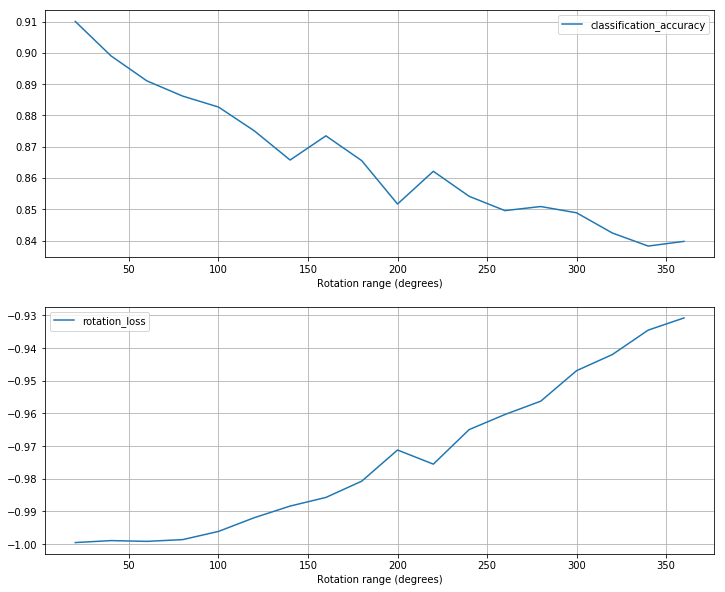

In [22]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.grid()
plt.plot(np.arange(10, 190, 10) * 2, data[:, 4], label='classification_accuracy')
plt.xlabel('Rotation range (degrees)')
plt.legend()
plt.subplot(212)
plt.grid()
plt.plot(np.arange(10, 190, 10) * 2, data[:, 1], label='rotation_loss')
plt.xlabel('Rotation range (degrees)')
plt.legend()

In [23]:
np.mean(diff_degrees, axis=1)

array([ 1.3832554 ,  1.77593382,  1.77201876,  1.92890577,  2.56119157,
        3.64702688,  4.17862631,  5.16323753,  5.82470787,  6.41361201,
        6.25119255,  7.47966726,  8.20807014,  8.64786822,  9.71438578,
        9.81888869, 10.68765806, 10.78373911])

In [ ]:
Y_pred, R_pred = model.predict(X_test_rot)

In [ ]:
diff_degree = np.abs(np.arctan2(R_pred[:, 0], R_pred[:, 1]) * 180 / np.pi - R_test)
diff_degree = np.array([diff if diff < 180 else 360 - diff for diff in diff_degree])
print(np.mean(diff_degree))

In [ ]:
Y_pred[:20]

In [ ]:
plt.figure(figsize=(12, 10))
plt.title('Histogram of absolute differences between the true and the predicted orientation (using full circle rotations)')
plt.hist(diff_degree, bins=35)
plt.grid()
plt.xlabel('Difference between true and predicted orientation')
plt.ylabel('Number of samples')
plt.show()

In [ ]:
xv = np.arange(0, 101)
plt.figure(figsize=(12, 10))
plt.grid()
plt.plot([np.percentile(diff_degree, x) for x in xv], xv)
plt.title('Percentile of test samples whose absolute difference between true and predicted orientation is below x \n(training using full circle)')
plt.xlabel('Difference in degrees between the true and the predicted orientation')
plt.ylabel('Percentage of predicted orientations below the corresponding difference')
plt.show()

In [ ]:
Y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
confusion_matrix = np.zeros((10, 10), dtype='int')

for y_true, y_pred in zip(Y_test_rot, Y_pred):
    confusion_matrix[y_true, y_pred] += 1

plt.figure(figsize=(12, 10))
plt.title('Confusion Matrix (Fashion MNIST)')
plt.imshow(confusion_matrix)
plt.colorbar()